# Dog Breed Prediction


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deeppanday","key":"7611091537d07c2135ac279a77967b83"}'}

install kaggle API

In [2]:
!pip install -q kaggle

In [3]:
# moving the kaggle API into ~/.kaggle folder
!mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/

# some permision for avoiding warnings
!chmod 600 ~/.kaggle/kaggle.json

create dir

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


Searching for dataset 

In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           3435          7  0.1764706        


Downloading the dataset

In [6]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 98% 677M/691M [00:06<00:00, 115MB/s]
100% 691M/691M [00:06<00:00, 111MB/s]
/content


In [7]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample.submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: dog_dataset/train/840dbad5

# Import library 

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import Adam

# data Preprocessing

In [9]:
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Visualize the number of each breed
breed_all = labels_all['breed']
breed_counts = breed_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [11]:
# Selecting the first 3 breed (for better computational power)

Class_name = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(Class_name))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [12]:
labels.shape

(357, 3)

In [13]:
from PIL import Image
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels),224,224,3),dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'],classes=Class_name)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = Image.open('dog_dataset/train/%s.jpg' % labels['id'][i])
  img = img.resize((224,224))
  img = np.array(img)
  X = np.expand_dims(img.copy(),axis=0)
  X_data[i] = X /255.0

100%|██████████| 357/357 [00:05<00:00, 65.57it/s]


In [14]:
print('\nTrain Images Shape: ',X_data.shape, 'size: {:,}'.format(X_data.size))
print('One-Hot-Encoded Output Shape: ',Y_data.shape, '{:,}'.format(Y_data.size))


Train Images Shape:  (357, 224, 224, 3) size: 53,738,496
One-Hot-Encoded Output Shape:  (357, 3) 1,071


# Building a model 

In [15]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16,kernel_size=(7,7),activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8,kernel_size=(5,5),activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_regularizer='l2'))
model.add(Dense(64,activation='relu',kernel_regularizer='l2'))
model.add(Dense(3,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [16]:
# compile the model 
model.compile(optimizer=Adam(0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
X_train_and_val,X_test,y_train_and_val,y_test = train_test_split(X_data,Y_data,test_size=0.1,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_and_val,y_train_and_val,test_size=0.2,random_state=42)


In [22]:
epochs = 40
batch_size =128

history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val,y_val),verbose=2)

Epoch 1/40
2/2 - 1s - loss: 2.3563 - accuracy: 0.8320 - val_loss: 1.9543 - val_accuracy: 0.8923 - 690ms/epoch - 345ms/step
Epoch 2/40
2/2 - 0s - loss: 2.3657 - accuracy: 0.8438 - val_loss: 3.0427 - val_accuracy: 0.6462 - 455ms/epoch - 228ms/step
Epoch 3/40
2/2 - 0s - loss: 2.9676 - accuracy: 0.6797 - val_loss: 1.8427 - val_accuracy: 0.9385 - 455ms/epoch - 227ms/step
Epoch 4/40
2/2 - 0s - loss: 2.1849 - accuracy: 0.8242 - val_loss: 2.2873 - val_accuracy: 0.7385 - 453ms/epoch - 226ms/step
Epoch 5/40
2/2 - 1s - loss: 2.0751 - accuracy: 0.8164 - val_loss: 1.6653 - val_accuracy: 0.9538 - 570ms/epoch - 285ms/step
Epoch 6/40
2/2 - 0s - loss: 2.0648 - accuracy: 0.8789 - val_loss: 1.7749 - val_accuracy: 0.9077 - 489ms/epoch - 245ms/step
Epoch 7/40
2/2 - 0s - loss: 2.0269 - accuracy: 0.8516 - val_loss: 1.9816 - val_accuracy: 0.8462 - 498ms/epoch - 249ms/step
Epoch 8/40
2/2 - 1s - loss: 1.8793 - accuracy: 0.8867 - val_loss: 1.6686 - val_accuracy: 0.9538 - 572ms/epoch - 286ms/step
Epoch 9/40
2/2 -

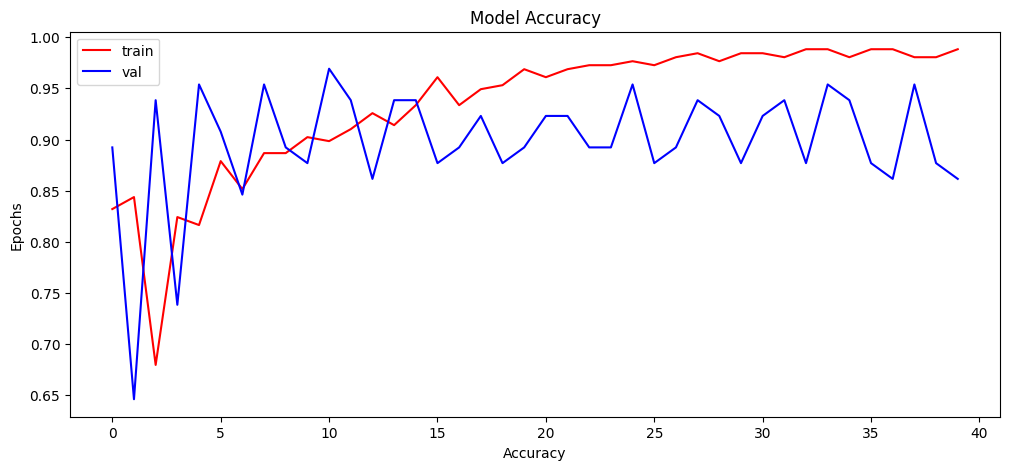

In [23]:
# Plotting graph 

plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['train','val'])
plt.show()


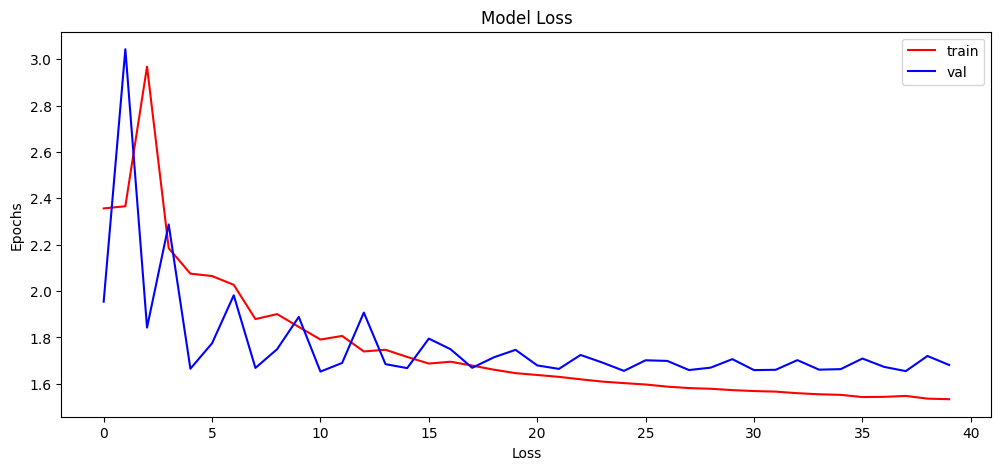

In [24]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='b')
plt.title('Model Loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(['train','val'])
plt.show()


Model Prediction

In [25]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test,y_test)
print('Accuracy over the test set:\n', round((score[1]*100),2),'%')

2/2 [==============================] - 0s 15ms/step - loss: 1.7329 - accuracy: 0.9167
Accuracy over the test set:
 91.67 %


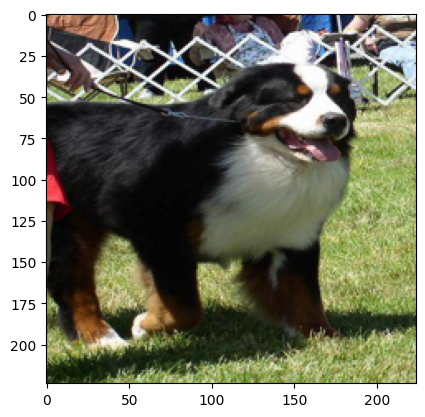

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [27]:
#Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

print('Originally : ',labels['breed'][np.argmax(y_test[1])])
print('Predicted : ',labels['breed'][np.argmax(y_pred[1])])


In [28]:
model.save("dog_breed.h5")